# Integration and reference mapping with multigrate

In this notebook, we demonstrate how to use Multigrate with scArches: we build a trimodal reference atlas with Multigrate by integrating CITE-seq and multiome data, and map unimodal as well as multimodal queries onto the reference. We use publically available datasets from NeurIPS 2021 workshop https://openproblems.bio/neurips_2021/.

In [1]:
import scarches as sca
import scanpy as sc
import anndata as ad
import numpy as np
import muon
import gdown
import json
import argparse
import warnings
import pandas as pd
import os
import multigrate as mtg
warnings.filterwarnings("ignore")

sc.set_figure_params(figsize=(4, 4), fontsize=8)
os.environ['CUDA_VISIBLE_DEVICES']='3'

 captum (see https://github.com/pytorch/captum).
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/root/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/root/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, default='teadog_paired_full_label_mask_new',
    help="Choose a task")
parser.add_argument('--experiment', type=str, default='ref_mapping',
    help="")
parser.add_argument('--kl', type=float, default=1e-1,
    help="")
parser.add_argument('--integ', type=int, default=3000,
    help="")
parser.add_argument('--inner', type=int, default=1,
    help="")
# o = parser.parse_args()
o, _ = parser.parse_known_args() 

task = o.task
data_root = '/dev/shm/processed/'+task
print(o.task)

data = {'rna':[], 'adt':[], 'atac':[]}
layers = {'rna':[], 'adt':[], 'atac':[]}
# labels = []
mask = {'rna':[], 'adt':[]}
mods = []

def creat_h5ad(mat, obs_names, label, batch):
    adata = sc.AnnData(mat)
    adata.obs_names = obs_names
    # adata.obs['l1'] = label
    adata.obs['batch'] = batch
    adata.obs['batch']  = adata.obs['batch'].astype('category')
    return adata

for i in range(8):
    m = []
    d = {}
    p = data_root+'/subset_'+str(i)
    
    # label = pd.read_csv(label_path[i], sep=',', index_col=0)
    for m in ['rna', 'adt', 'atac']:
        if os.path.exists(p+'/mat/'+m+'.csv'):
            mods.append(m)
            print(i, m)

            mat = pd.read_csv(p+'/mat/'+m+'.csv', sep=',', index_col=0)
            cellnames = pd.read_csv(p+'/cell_names.csv', sep=',', index_col=0).values.flatten()
            # label.index = cellnames
            adata = creat_h5ad(mat, cellnames, None, i)

            print(adata)

            if m != 'atac':
                mask[m].append(pd.read_csv(p+'/mask/'+m+'.csv', index_col=0))
            if m=='adt':
                adata.layers['counts'] = adata.X.copy()
            elif m=='rna':
                adata.layers['counts'] = adata.X.copy()
            elif m=='atac':
                adata.layers['counts'] = adata.X.copy()
                
            data[m].append(adata)
        else:
            data[m].append(None)
        

# %%
if o.inner:
    final_mask = {'rna':None, 'adt':None}
    for m in ['rna', 'adt']:
        for mk in  mask[m]:
            if final_mask[m] is None:
                final_mask[m] = mk.values.astype('bool')[0]
            else:
                final_mask[m] = final_mask[m] & mk.values.astype('bool')[0]
        print(final_mask[m].sum())

    rna_dim = None
    for m in ['rna', 'adt']:
        for i in range(len(data[m])):
            if data[m][i] is not None:
                data[m][i] = data[m][i][:, final_mask[m]]   
                print(data[m][i])

for m in ['rna', 'adt', 'atac']:
    for i in range(8):
        if data[m][i] is not None and m=='rna':
            rna = data[m][i]
            sc.pp.normalize_total(rna, target_sum=1e4)
            sc.pp.log1p(rna)
            layers[m].append('counts')

        elif data[m][i] is not None and m=='adt':
            adt = data[m][i]
            adt.X = adt.layers['counts'].copy()
            muon.prot.pp.clr(adt)
            print(np.max(adt.X))
            adt.layers['clr'] = adt.X.copy()
            layers[m].append('clr')

        elif data[m][i] is not None and m=='atac':
            atac = data[m][i]
            muon.atac.pp.tfidf(atac, scale_factor=1e4)
            atac
            atac.layers['tf-idf'] = atac.X.copy()
            atac.X = atac.layers['counts'].copy()
            sc.pp.normalize_total(atac, target_sum=1e4)
            sc.pp.log1p(atac)
            atac.layers['log-norm'] = atac.X.copy()
            layers[m].append('log-norm')

        else:
            layers[m].append(None)
print(data)
print(layers)

# %%
mod = []
losses = []
for i in ['rna', 'atac', 'adt']:
    if i in mods:
        mod.append(i)
        if i=='rna':
            losses.append('nb')
        else:
            losses.append('mse')

# adata = sca.models.organize_multiome_anndatas(
#     adatas = [data['rna'], data['atac'], data['adt']],    # a list of anndata objects per modality, RNA-seq always goes first
#     layers = [layers['rna'], layers['atac'], layers['adt']], # if need to use data from .layers, if None use .X
# )


teadog_paired_full_label_mask_new
0 adt
AnnData object with n_obs × n_vars = 9579 × 213
    obs: 'batch'
0 atac
AnnData object with n_obs × n_vars = 9579 × 31787
    obs: 'batch'
1 rna
AnnData object with n_obs × n_vars = 9096 × 4055
    obs: 'batch'
1 atac
AnnData object with n_obs × n_vars = 9096 × 31787
    obs: 'batch'
2 rna
AnnData object with n_obs × n_vars = 7318 × 4055
    obs: 'batch'
2 adt
AnnData object with n_obs × n_vars = 7318 × 213
    obs: 'batch'
3 rna
AnnData object with n_obs × n_vars = 4817 × 4055
    obs: 'batch'
3 adt
AnnData object with n_obs × n_vars = 4817 × 213
    obs: 'batch'
3 atac
AnnData object with n_obs × n_vars = 4817 × 31787
    obs: 'batch'
4 adt
AnnData object with n_obs × n_vars = 5342 × 213
    obs: 'batch'
4 atac
AnnData object with n_obs × n_vars = 5342 × 31787
    obs: 'batch'
5 rna
AnnData object with n_obs × n_vars = 6181 × 4055
    obs: 'batch'
5 atac
AnnData object with n_obs × n_vars = 6181 × 31787
    obs: 'batch'
6 rna
AnnData object wit

In [55]:
label_path = [
    './data/sct/atac+rna+adt/dogma_label_mask/P1/label_seurat/l1.csv',
    './data/sct/atac+rna+adt/dogma_label_mask/P2/label_seurat/l1.csv',
    './data/sct/atac+rna+adt/dogma_label_mask/P3/label_seurat/l1.csv',
    './data/sct/atac+rna+adt/dogma_label_mask/P4/label_seurat/l1.csv',
    './data/sct/atac+rna+adt/tea_label_mask/P5/label_seurat/l1.csv',
    './data/sct/atac+rna+adt/tea_label_mask/P6/label_seurat/l1.csv',
    './data/sct/atac+rna+adt/tea_label_mask/P7/label_seurat/l1.csv',
    './data/sct/atac+rna+adt/tea_label_mask/P8/label_seurat/l1.csv']
labels = []
for i in label_path:
    labels.append(pd.read_csv(i, index_col=0))

In [3]:
cell_names_all = []
for i in range(8):
    p = data_root+'/subset_'+str(i)
    cell_names_all.append(pd.read_csv(p+'/cell_names.csv', sep=',', index_col=0).values.flatten())

In [56]:
for i in range(8):
    labels[i].index = cell_names_all[i]

## Initialize the model

Next, we initialize the model. If using raw counts for RNA-seq, use NB loss, if normalized counts, use MSE. For ADT we use CLR-normalized counts and MSE loss. We need to specify `mmd='marginal'` and set the coeficient to the integration loss if we want to later map unimodal data onto this reference.

## Map and Query


## create triple modality model

In [3]:
# rna = data['rna']
# adt = data['adt']
# atac = data['atac']

In [63]:
adata_all = mtg.data.organize_multiome_anndatas(
    adatas = [data['rna'], data['atac'], data['adt']],    # a list of anndata objects per modality, RNA-seq always goes first
    layers = [layers['rna'], layers['atac'], layers['adt']], # if need to use data from .layers, if None use .X
)
print(adata_all)

AnnData object with n_obs × n_vars = 53356 × 34925
    obs: 'group', 'batch'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'


In [9]:
adata_all = adata_all[np.concatenate(cell_names_all)]

In [64]:
adata_all.obs['label'] = pd.concat(labels)

In [68]:
adata_ref = adata_all[(adata_all.obs['batch']==0) | (adata_all.obs['batch']==1)]
print(adata_ref)

View of AnnData object with n_obs × n_vars = 18675 × 34925
    obs: 'group', 'batch', 'label'
    var: 'modality'
    uns: 'modality_lengths'
    layers: 'counts'


In [70]:
sca.models.MultiVAE.setup_anndata(
    adata_ref,
    categorical_covariate_keys=['batch'],
    rna_indices_end=adata_ref.uns['modality_lengths'][0],
)

In [71]:
model = sca.models.MultiVAE(
    adata_ref,
    losses=['nb', 'mse','mse'],
    loss_coefs={'kl': 1e-1,
                'integ': 3000,
                },
    z_dim=32,
    integrate_on='batch',
    mmd='marginal')

In [72]:
model.train(use_gpu=True, max_epochs=500)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 324/500:  65%|██████▍   | 324/500 [25:07<13:38,  4.65s/it, loss=5.43e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 5438.562. Signaling Trainer to stop.


In [76]:
model.get_latent_representation()
os.makedirs('./result/teadog_paired_full_label_mask_new/multigrate_obo/default/predict/susbet_0/z/joint/')
pd.DataFrame(adata_ref[adata_ref.obs['batch']==0].obsm['latent']).to_csv('./result/teadog_paired_full_label_mask_new/multigrate_obo/default/predict/subset_0/z/joint/00.csv', index=False, header=False)
os.makedirs('./result/teadog_paired_full_label_mask_new/multigrate_obo/default/predict/subset_1/z/joint/')
pd.DataFrame(adata_ref[adata_ref.obs['batch']==1].obsm['latent']).to_csv('./result/teadog_paired_full_label_mask_new/multigrate_obo/default/predict/subset_1/z/joint/00.csv', index=False, header=False)

In [146]:
mods =[
    ["atac", "adt" ],
    ["atac", "rna" ],
    ["rna", "adt" ],
    ["atac", "rna", "adt" ],
    ["atac", "adt"] ,
    ["atac", "rna"] ,
    ["rna", "adt"] ,
    ["atac", "rna", "adt"] ]

In [149]:
cell_num = [i.shape[0] for i in cell_names_all]
cell_num

[9579, 9096, 7318, 4817, 5342, 6181, 4163, 6860]

In [ ]:
import torch
def get_impute(model2, adata, target_modality):
    model2.setup_anndata(adata,
    rna_indices_end=adata_rna.uns['modality_lengths'][0])
    with torch.no_grad():
        model2.module.eval()
        if not model2.is_trained_:
            raise RuntimeError("Please train the model first.")
        
    adata = model2._validate_anndata(adata)
    scdl = model2._make_data_loader(adata=adata, batch_size=256)
    imputed = []
    for tensors in scdl:
        _, generative_outputs = model2.module.forward(tensors, compute_loss=False)

        rs = generative_outputs["rs"]
        r = rs[target_modality]
        imputed += [r.cpu()]
    return torch.cat(imputed).squeeze().detach().numpy()

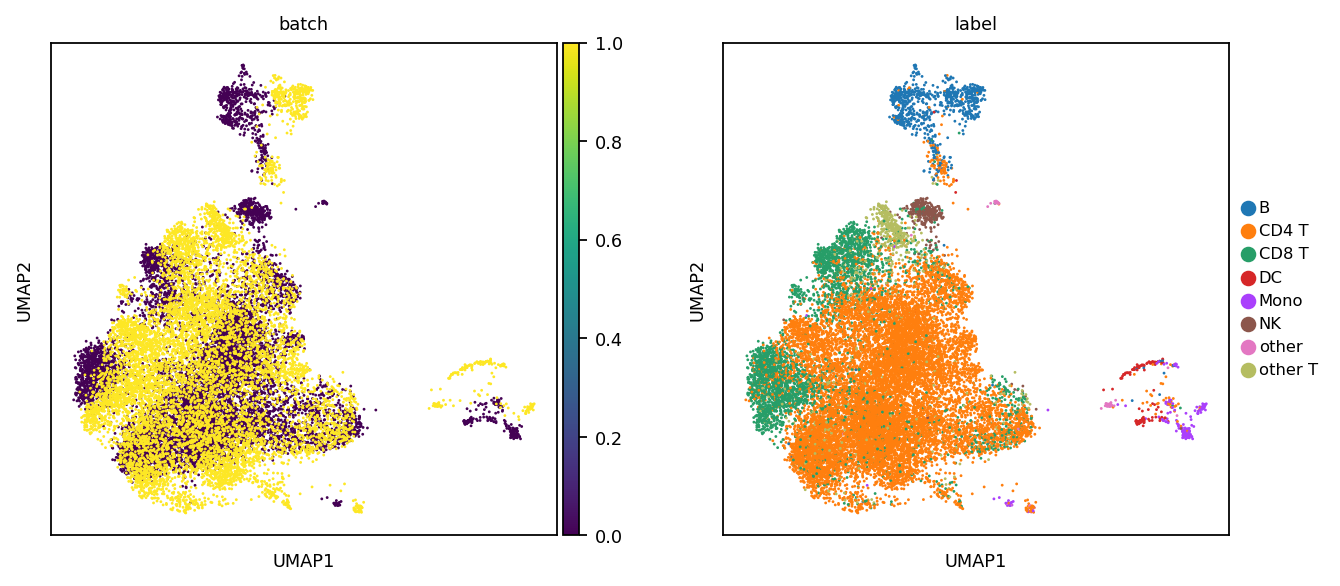

In [ ]:
sc.pp.neighbors(adata_ref, use_rep='latent')
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color=['batch', 'label'])

In [186]:
# model2.save('./result/teadog_paired_full_label_mask_new/multigrate_obo/train')

In [ ]:
model2 = model
for i in range(2, 8):
    adata_q = adata_all[(adata_all.obs['batch']==i)]
    sca.models.MultiVAE.setup_anndata(
    adata_q,
    categorical_covariate_keys=['batch'],
    rna_indices_end=adata_q.uns['modality_lengths'][0])
    q_model = sca.models.MultiVAE.load_query_data(adata_q, model2)
    q_model.train(weight_decay=0)
    q_model.get_latent_representation(adata=adata_q)
    os.makedirs('./result/teadog_paired_full_label_mask_new/multigrate_obo/default/predict/subset_%d/z/joint/'%(i))
    pd.DataFrame(adata_q.obsm['latent']).to_csv('./result/teadog_paired_full_label_mask_new/multigrate_obo/default/predict/subset_%d/z/joint/00.csv'%(i), index=False, header=False)
    model2 = q_model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 200/200: 100%|██████████| 200/200 [04:31<00:00,  1.35s/it, loss=2.63e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:31<00:00,  1.36s/it, loss=2.63e+03, v_num=1]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 200/200: 100%|██████████| 200/200 [03:21<00:00,  1.06s/it, loss=7.01e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it, loss=7.01e+03, v_num=1]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 200/200: 100%|██████████| 200/200 [03:34<00:00,  1.13s/it, loss=4.67e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:34<00:00,  1.07s/it, loss=4.67e+03, v_num=1]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 200/200: 100%|██████████| 200/200 [03:32<00:00,  1.07s/it, loss=6.15e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [03:32<00:00,  1.06s/it, loss=6.15e+03, v_num=1]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 200/200: 100%|██████████| 200/200 [02:44<00:00,  1.11it/s, loss=1.73e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:44<00:00,  1.22it/s, loss=1.73e+03, v_num=1]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 200/200: 100%|██████████| 200/200 [04:40<00:00,  1.34s/it, loss=6.24e+03, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:40<00:00,  1.40s/it, loss=6.24e+03, v_num=1]
